# facial-emotion-detection-and-classification

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Importing the libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
import cv2
import os
import pickle
import random

### Let's visualize some image

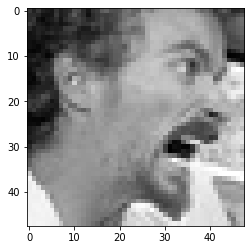

In [ ]:
test_img = cv2.imread('/content/drive/MyDrive/Major Project/test-emotion-detection/FER-2013 train and test wala/FER-2013-balanced/angry/PrivateTest_10304478.jpg')
plt.imshow(test_img)
plt.show()

In [ ]:
test_img.shape

(48, 48, 3)

### Taking all the images from the image dataset

In [ ]:
path_to_data = '/content/drive/MyDrive/Major Project/test-emotion-detection/FER-2013 train and test wala/FER-2013-balanced/'
img_dirs = []
for entry in os.scandir(path_to_data):
    if entry.is_dir():
        img_dirs.append(entry.path)

In [ ]:
img_dirs

['/content/drive/MyDrive/Major Project/test-emotion-detection/FER-2013 train and test wala/FER-2013-balanced/sad',
 '/content/drive/MyDrive/Major Project/test-emotion-detection/FER-2013 train and test wala/FER-2013-balanced/surprise',
 '/content/drive/MyDrive/Major Project/test-emotion-detection/FER-2013 train and test wala/FER-2013-balanced/happy',
 '/content/drive/MyDrive/Major Project/test-emotion-detection/FER-2013 train and test wala/FER-2013-balanced/angry',
 '/content/drive/MyDrive/Major Project/test-emotion-detection/FER-2013 train and test wala/FER-2013-balanced/disgust',
 '/content/drive/MyDrive/Major Project/test-emotion-detection/FER-2013 train and test wala/FER-2013-balanced/neutral',
 '/content/drive/MyDrive/Major Project/test-emotion-detection/FER-2013 train and test wala/FER-2013-balanced/fear']

In [ ]:
emotions = []
for img_dir in img_dirs:
    emotion_name = img_dir.split('/')[-1]
    emotions.append(emotion_name)

In [ ]:
emotions

['sad', 'surprise', 'happy', 'angry', 'disgust', 'neutral', 'fear']

In [ ]:
data = []
for emotion in emotions:
    path = os.path.join(path_to_data, emotion)
    label = emotions.index(emotion)
    print('{} --> {}'.format(emotion, label))
    for img in os.listdir(path):
        imgpath = os.path.join(path, img)
        emotion_img = cv2.imread(imgpath, 0)
        try:
            emotion_img = cv2.resize(emotion_img, (48, 48))
            image = np.array(emotion_img).flatten()
        
            data.append([image, label])
        except Exception as e:
            pass

sad --> 0
surprise --> 1
happy --> 2
angry --> 3
disgust --> 4
neutral --> 5
fear --> 6


In [ ]:
print(len(data))

3653


### Splitting the data into features and labels where X --> features & y --> labels

In [ ]:
random.shuffle(data)
X = []
y = []

for feature, label in data:
    X.append(feature)
    y.append(label)

### Splitting the data into training and test set

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

### Fitting the model into train set

In [ ]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto',probability=True),
        'params' : {
            'svc__C': [1,10,100,1000],
            'svc__kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators': [1,5,10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'logisticregression__C': [1,5,10]
        }
    }
}

In [ ]:
scores = []
best_estimators = {}
for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf = GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

,model,best_score,best_params
0,svm,0.383980,"{'svc__C': 100, 'svc__kernel': 'rbf'}"
1,random_forest,0.296023,{'randomforestclassifier__n_estimators': 10}
2,logistic_regression,0.302538,{'logisticregression__C': 1}


In [ ]:
best_estimators

{'logistic_regression': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('logisticregression',
                  LogisticRegression(C=1, solver='liblinear'))]),
 'random_forest': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('randomforestclassifier',
                  RandomForestClassifier(n_estimators=10))]),
 'svm': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('svc', SVC(C=100, gamma='auto', probability=True))])}

In [ ]:
best_estimators['svm'].score(X_test,y_test)

0.42818057455540354

In [ ]:
best_estimators['logistic_regression'].score(X_test,y_test)

0.3064295485636115

In [ ]:
best_estimators['random_forest'].score(X_test,y_test)

0.3228454172366621

In [ ]:
best_clf = best_estimators['svm']

In [ ]:
best_clf

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(C=100, gamma='auto', probability=True))])

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, best_clf.predict(X_test))
cm

array([[48,  7, 14,  6,  7,  8,  9],
       [ 7, 74,  7, 11,  3,  9, 15],
       [ 8,  7, 57, 17,  5, 17, 13],
       [15, 10, 10, 19, 11, 12, 16],
       [ 6,  4,  5,  5, 74,  6,  8],
       [ 9,  7,  8, 10,  7, 22,  9],
       [14, 23, 12, 16, 11, 14, 19]])

Text(69.0, 0.5, 'Truth')

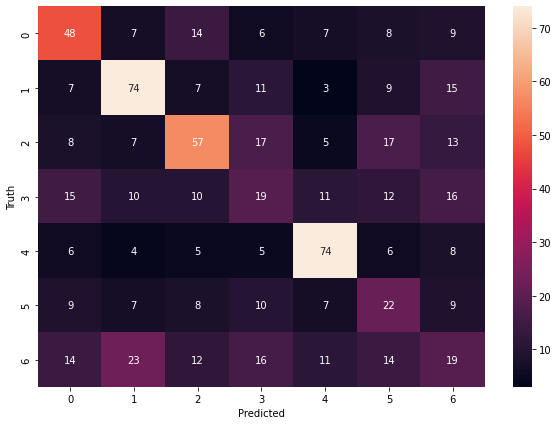

In [ ]:
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [ ]:
cr_svm = classification_report(y_test, best_clf.predict(X_test))
print(cr_svm)

              precision    recall  f1-score   support

           0       0.45      0.48      0.47        99
           1       0.56      0.59      0.57       126
           2       0.50      0.46      0.48       124
           3       0.23      0.20      0.21        93
           4       0.63      0.69      0.65       108
           5       0.25      0.31      0.28        72
           6       0.21      0.17      0.19       109

    accuracy                           0.43       731
   macro avg       0.40      0.41      0.41       731
weighted avg       0.42      0.43      0.42       731

